Import necessary packages/libraries

In [580]:
!pip install nltk

In [581]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('words')

from sklearn.feature_extraction import DictVectorizer

from random import shuffle, seed

%matplotlib inline
pd.options.display.max_colwidth=500

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [582]:
#Stopwords 
from nltk.corpus import stopwords

#Libraries for lemmatizing.
from nltk.stem import WordNetLemmatizer

# Tokenizer
from nltk.tokenize import word_tokenize

# Regular expression library
import re

# Package 'words' from nltk corpus
from nltk.corpus import words

# Import jaccard distance
from nltk.util import ngrams

#Spellchecker library
!pip install pyspellchecker
from spellchecker import SpellChecker

# Import pos tag
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')

# Import sentiment analyzer
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Import tf-idf
from sklearn.feature_extraction.text import TfidfTransformer

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Load the data (train/test) and split the train data into training/validation set

In [583]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
all_train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


In [584]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # need to sort to ensure same initial order

shuffle(episode_scenes)

print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]
print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)

1394
1254 140


In [585]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [586]:
train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training
...,...,...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE,1399-55,training
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE,1399-55,training
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE,1399-55,training
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE,1399-55,training


In [587]:
val_data

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
56,1350,18,BRANNINGS' HOUSE INT NIGHT,TANYA,Who's that?,FEMALE,1350-18,heldout
57,1350,18,BRANNINGS' HOUSE INT NIGHT,MAX,Tanya! Tanya it's me. I wanna give Oscar a New Year kiss. Tan?,MALE,1350-18,heldout
58,1350,18,BRANNINGS' HOUSE INT NIGHT,SEAN,Right. I'll have a word.,MALE,1350-18,heldout
59,1350,18,BRANNINGS' HOUSE INT NIGHT,TANYA,"No no no leave it, leave it. He ain't got a key. He'll go away. Do you want some crisps?",FEMALE,1350-18,heldout
60,1350,18,BRANNINGS' HOUSE INT NIGHT,MAX,"Who, who you got in there, Tan? Tan, I've got a right to know who my kids are being exposed to. I bet you ain't got anyone have ya? You're just sitting there with a bottle of wine all on your Jack, Tan?",MALE,1350-18,heldout
...,...,...,...,...,...,...,...,...
15268,1399,29,[NAME] & [NAME]'S HOUSE INT NIGHT,STACEY,"I asked him to leave you. I asked him again and again. I begged him. And if he had. I'd have been with him. I'd have been with him now. So it might suit you to think that it was all Max but it wasn't, not really, not in the end.",FEMALE,1399-29,heldout
15269,1399,29,[NAME] & [NAME]'S HOUSE INT NIGHT,TANYA,Why you telling me all this eh?,FEMALE,1399-29,heldout
15270,1399,29,[NAME] & [NAME]'S HOUSE INT NIGHT,STACEY,"Because I don't want you using Sean to punish him, I don't want you wrecking your family cause of me. I just, I just want it all over.",FEMALE,1399-29,heldout
15271,1399,29,[NAME] & [NAME]'S HOUSE INT NIGHT,TANYA,It is over. It's all over. Will you please just go home now and leave me alone.,FEMALE,1399-29,heldout


# Question 1

In this part, the function 'pre_process' will be modified to improve the performance:
- **Before**: Only using string split() function with whitespace as default separator
- **After**: Evaluate different preprocessing methods (such as lowercase converting, lematization, etc.) with an exhaustive approach. The strategy is to check the performance of every combination of potential preprocessing methods.

*Remarks: Other functions would be kept unchanged*

In [588]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for line, name, gender in zip(df.Line, df.Character_name, df.Gender):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)   + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
    return character_docs

In [589]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # need to sort to ensure same initial order

shuffle(episode_scenes)

print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]
print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)

1394
1254 140


In [590]:
def to_feature_vector_dictionary(character_doc, extra_features):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] += 1
    return counts  

In [591]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, []) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, []) for name, doc in corpus])
    
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix

In [592]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [593]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
#     print("mean rank", np.mean(rankings))
#     print("mean cosine similarity", mean_cosine_similarity)
#     print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df, correct, test_labels)

In [594]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

### Modify the 'pre_process' function

Strategy: the exhaustive method would be used to evaluate every combination of potential preprocessing approaches. In total, this part will aim to focus on 5 preprocessing ways to be added, namely:
- Use word_tokenize method from nltk to have cleaner tokens
- Convert tokens into lowercase
- Remove punctuation
- Remove stopwords (too common words)
- Lemmatization

With the above 5 methods, we would have 2^n sets/combinations of methods (32 in this case) which need to be evaluated

In [595]:
# The modified function looks like below:
def pre_process(character_text, switches=[], string_split = False):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    stopword = stopwords.words("english") # Initialize stopword list
    lemmatizer = WordNetLemmatizer() # Initialize lemmatizer
    if string_split==True or len(switches)==0:
        tokens = character_text.split()
    else:
        if 'tokenize' in switches:
            tokens = word_tokenize(character_text)
        else:
            tokens = character_text.split()

        if 'lower' in switches:
            tokens = [word.lower() for word in tokens] # Convert into lowercase

        if 'punc_remove' in switches:
            tokens = [word for word in tokens if word.isalpha() or word == '_eol_' or word =='_EOL_'] # Remove punctuation but still keep "_EOL_"

        if 'stopword_remove' in switches:
            tokens = [word for word in tokens if not word in stopword] # Stopword removal

        if 'lematize' in switches:
            try:
                tokens = [lemmatizer.lemmatize(word, pos = "v") for word in tokens] # Lemmatize verbs
                tokens = [lemmatizer.lemmatize(word, pos = "n") for word in tokens] # Lemmatize nouns
                tokens = [lemmatizer.lemmatize(word, pos = "a") for word in tokens] # Lemmatize adjectives
                tokens = [lemmatizer.lemmatize(word, pos = "r") for word in tokens] # Lemmatize adverbs
                tokens = [lemmatizer.lemmatize(word, pos = "s") for word in tokens] # Lemmatize satellite adjectives
            except:
                pass
    
    return tokens

#### Base function: simply use str.split() for tokenizing (whitespace as separator)

In [596]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)

# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc, string_split=True)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]
training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True) # transform the train_feature_matrix

# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc, string_split=True)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False) # transform the val_feature_matrix, don't fit

# Print result
mean_rank, mean_cosine_simliarity, acc, df, correct, test_labels = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
print("mean rank", mean_rank)
print("mean cosine similarity", mean_cosine_simliarity)
print(correct, "correct out of", len(test_labels), "/ accuracy:", acc)

mean rank 4.5
mean cosine similarity 0.9128136458100018
4 correct out of 16 / accuracy: 0.25


In [597]:
# Define a function to create all preprocessing combinations
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [598]:
# Evaluate every combination of preprocessing methods
pre_process_methods = ['tokenize', 'lower', 'punc_remove', 'stopword_remove', 'lematize']
combos = [list(p) for p in powerset(pre_process_methods)][1:]
method_combos=[]
mean_rank_=[]
mean_cosine_similarity=[]
accuracy=[]
for i in combos:
    # print out the number of words each character has in the training set
    # only use the first 360 lines of each character
    train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)

    # create list of pairs of (character name, pre-processed character) 
    training_corpus = [(name, pre_process(doc, switches=i)) for name, doc in sorted(train_character_docs.items())]
    train_labels = [name for name, doc in training_corpus]
    training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True) # transform the train_feature_matrix

    # get the validation data- only 40 lines used for each character
    val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)

    # create list of pairs of (character name, pre-processed character) 
    val_corpus = [(name, pre_process(doc, switches=i)) for name, doc in sorted(val_character_docs.items())]
    val_labels = [name for name, doc in val_corpus]
    val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False) # transform the val_feature_matrix, don't fit

    # Print result
    mean_rank, mean_cosine_simliarity, acc, df, correct, test_labels = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
    method_combos.append(i)
    mean_rank_.append(mean_rank)
    mean_cosine_similarity.append(mean_cosine_simliarity)
    accuracy.append(acc)

# Convert the result into 1 dataframe
combo=[]
for i in method_combos:
    combo.append(str(i))

method_result = pd.DataFrame(combo, columns=['method_combos'])
method_result['mean_rank'] = mean_rank_
method_result['mean_cosine_similarity'] = mean_cosine_similarity
method_result['accuracy'] = accuracy

# Sort dataframe by mean_rank to see which combos has the lowest score
method_result.sort_values(by='mean_rank', ascending=True)

,method_combos,mean_rank,mean_cosine_similarity,accuracy
30,"['tokenize', 'lower', 'punc_remove', 'stopword_remove', 'lematize']",2.5000,0.941877,0.6875
28,"['tokenize', 'punc_remove', 'stopword_remove', 'lematize']",2.6875,0.941691,0.6875
25,"['tokenize', 'lower', 'punc_remove', 'stopword_remove']",2.6875,0.942535,0.5625
18,"['tokenize', 'punc_remove', 'stopword_remove']",3.0625,0.942017,0.6250
5,"['tokenize', 'lower']",3.2500,0.949986,0.4375
10,"['lower', 'stopword_remove']",3.3125,0.936421,0.6250
8,"['tokenize', 'lematize']",3.3750,0.950316,0.4375
0,['tokenize'],3.3750,0.949047,0.3750
3,['stopword_remove'],3.4375,0.933139,0.5000
17,"['tokenize', 'lower', 'lematize']",3.4375,0.951114,0.4375


**The combination of \['tokenize', 'lower', 'punc_remove', 'stopword_remove', 'lematize'\] has proved to improve the performance the most. Therefore, we will use choose these 5 methods to be implemented in the new 'pre_process' function**

The result on validation set returns mean rank of 2.5, much lower than the base model (2.5 < 4.5)

In [599]:
# The chosen pro_process function would be:
def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    stopword = stopwords.words("english") # Initialize stopword list
    lemmatizer = WordNetLemmatizer() # Initialize lemmatizer
    tokens = word_tokenize(character_text) # use word_tokenize method for cleaner tokens
    tokens = [word.lower() for word in tokens] # Convert into lowercase
    tokens = [word for word in tokens if word.isalpha() or word == '_eol_' or word == '_EOL_'] # Remove punctuation but still keep "_EOL_"
    tokens = [word for word in tokens if not word in stopword] # Stopword removal
    try:
        tokens = [lemmatizer.lemmatize(word, pos = "v") for word in tokens] # Lemmatize verbs
        tokens = [lemmatizer.lemmatize(word, pos = "n") for word in tokens] # Lemmatize nouns
        tokens = [lemmatizer.lemmatize(word, pos = "a") for word in tokens] # Lemmatize adjectives
        tokens = [lemmatizer.lemmatize(word, pos = "r") for word in tokens] # Lemmatize adverbs
        tokens = [lemmatizer.lemmatize(word, pos = "s") for word in tokens] # Lemmatize satellite adjectives
    except:
        pass
    return tokens

In [600]:
# The corresponding performance with the selected pre_process function would be:

# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)

# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]
training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True) # transform the train_feature_matrix

# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False) # transform the val_feature_matrix, don't fit

# Print result
mean_rank, mean_cosine_simliarity, acc, df, correct, test_labels = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
print("mean rank", mean_rank)
print("mean cosine similarity", mean_cosine_simliarity)
print(correct, "correct out of", len(test_labels), "/ accuracy:", acc)

mean rank 2.5
mean cosine similarity 0.9418767551883283
11 correct out of 16 / accuracy: 0.6875


# Question 2

The strategy is to add extra features by using different techniques, such as ngrams, POS tagging or sentiment analysis.

What needs to modified is the function 'to_feature_vector_dictionary' along with some corresponding adjustment in 'pre_process' function to extract more features for model improvement. For the other functions, we would keep the same.

In this part, we will aim to add and evaluate these features (and their combination as well):
- Bigrams/Trigrams/4grams
- POS tagging of bigrams/trigrams/4grams
- Sentiment analysis (positive/neutral/negative)

After that, we will look at how to reduce the dimensionality to keep only good/meaningful features (by min/max document frequency or other techniques if possible)

*Remark: we will use the update the 'pre_process' function according to question 1 before any modification*

### Try adding extra features

In [601]:
# First, update the pre_process with result from question 1
# Next, extra features are added
def pre_process(character_text, extra):
    stopword = stopwords.words("english") # Initialize stopword list
    lemmatizer = WordNetLemmatizer() # Initialize lemmatizer
    tokens = word_tokenize(character_text) # use word_tokenize method for cleaner tokens
    tokens = [word.lower() for word in tokens] # Convert into lowercase
    tokens = [word for word in tokens if word.isalpha() or word == '_eol_' or word == '_EOL_'] # Remove punctuation but still keep "_EOL_"
    tokens = [word for word in tokens if not word in stopword] # Stopword removal
    try:
        tokens = [lemmatizer.lemmatize(word, pos = "v") for word in tokens] # Lemmatize verbs
        tokens = [lemmatizer.lemmatize(word, pos = "n") for word in tokens] # Lemmatize nouns
        tokens = [lemmatizer.lemmatize(word, pos = "a") for word in tokens] # Lemmatize adjectives
        tokens = [lemmatizer.lemmatize(word, pos = "r") for word in tokens] # Lemmatize adverbs
        tokens = [lemmatizer.lemmatize(word, pos = "s") for word in tokens] # Lemmatize satellite adjectives
    except:
        pass
    
    extra_feature = []
    
    # Extract bigrams
    if 'bigrams' in extra:
        ngram = ngrams(tokens, 2)
        for i in ngram:
            bigrams = i[0] + "@" + i[1]
            extra_feature.append(bigrams)
    
    # Extract trigrams
    if 'trigrams' in extra:
        ngram = ngrams(tokens, 3)
        for i in ngram:
            trigrams = i[0] + "@" + i[1] + '@' + i[2]
            extra_feature.append(trigrams)

    if '_4grams' in extra:
        ngram = ngrams(tokens, 4)
        for i in ngram:
            _4grams = i[0] + "@" + i[1] + '@' + i[2] + '@' + i[3]
            extra_feature.append(_4grams)
        
    # Extract POS-tagging for ngrams
    tags = []
    pos = pos_tag(tokens)
    for a, b in pos:
        if a == '_eol_':
            tags.append('_eol_')
        else:
            tags.append(b[:2])
    if 'pos2' in extra:
        ngram = ngrams(tags, 2)
        for i in ngram:
            ngrams_tags = i[0] + "@" + i[1]
            extra_feature.append(ngrams_tags)
    if 'pos3' in extra:
        ngram = ngrams(tags, 3)
        for i in ngram:
            ngrams_tags = i[0] + "@" + i[1] + "@" + i[2]
            extra_feature.append(ngrams_tags)
    if 'pos4' in extra:
        ngram = ngrams(tags, 4)
        for i in ngram:
            ngrams_tags = i[0] + "@" + i[1] + "@" + i[2] + "@" + i[3]
            extra_feature.append(ngrams_tags)
    
    # Sentiment Analysis - pos/neu/neg
    if 'sentiment' in extra:
        sid = SentimentIntensityAnalyzer()
        for sent in character_text.split("_EOL_"):
            sentiment = sid.polarity_scores(sent)
            if sentiment['neg'] > sentiment['neu'] and sentiment['neg'] > sentiment['pos']:
                extra_feature.append('neg')

            if sentiment['neu'] > sentiment['neg'] and sentiment['neu'] > sentiment['pos']:
                extra_feature.append('neu')
            else:
                extra_feature.append('pos')
    return tokens, extra_feature

In [602]:
# Modify the function 'to_feature_vector_dictionary' accordingly to include extra features
# Also set the maximum document frequency for feature selection
def to_feature_vector_dictionary(character_doc, extra_features):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    
    # Set max doc frequency => choose a random 'max frequency' of 60 to run first (will find the optimal value later)
    for key, value in counts.copy().items():
        if value > 60:
            del counts[key]
            
    # Add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        if feature not in counts.keys():
            counts[feature] = 1
        else:
            counts[feature] += 1
    
    return counts  

In [603]:
# The 'create_document_matrix_from_corpus' also needs a slight modification to include extra features extracted
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts

def create_document_matrix_from_corpus(corpus, fitting=False):
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc[0], doc[1]) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc[0], doc[1]) for name, doc in corpus])
    return doc_feature_matrix

In [604]:
# Evaluate all combinations of extra features and select the one with lowest mean rank
feature = ['bigrams', 'trigrams', '_4grams', 'pos2', 'pos3', 'pos4', 'sentiment']
feature_combos = [list(p) for p in powerset(feature)][1:]
features_combos=[]
mean_rank_=[]
mean_cosine_similarity=[]
accuracy=[]
for i in feature_combos:
    # print out the number of words each character has in the training set
    # only use the first 360 lines of each character
    train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)

    # create list of pairs of (character name, pre-processed character) 
    training_corpus = [(name, pre_process(doc, extra=i)) for name, doc in sorted(train_character_docs.items())]
    train_labels = [name for name, doc in training_corpus]
    training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True) # transform the train_feature_matrix

    # get the validation data- only 40 lines used for each character
    val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)

    # create list of pairs of (character name, pre-processed character) 
    val_corpus = [(name, pre_process(doc, extra=i)) for name, doc in sorted(val_character_docs.items())]
    val_labels = [name for name, doc in val_corpus]
    val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False) # transform the val_feature_matrix, don't fit

    # Print result to list
    mean_rank, mean_cosine_simliarity, acc, df, correct, test_labels = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
    features_combos.append(i)
    mean_rank_.append(mean_rank)
    mean_cosine_similarity.append(mean_cosine_simliarity)
    accuracy.append(acc)
    
combo=[]
for i in features_combos:
    combo.append(str(i))
    
feature_selection_result = pd.DataFrame(combo, columns=['features_combos'])
feature_selection_result['mean_rank'] = mean_rank_
feature_selection_result['mean_cosine_similarity'] = mean_cosine_similarity
feature_selection_result['accuracy'] = accuracy

feature_selection_result.sort_values(by='mean_rank', ascending=True).head(10)

,features_combos,mean_rank,mean_cosine_similarity,accuracy
8,"['bigrams', '_4grams']",1.5625,0.526678,0.8125
28,"['bigrams', 'trigrams', '_4grams']",1.5625,0.492886,0.8125
1,['trigrams'],1.6250,0.573163,0.7500
0,['bigrams'],1.6875,0.554721,0.6875
2,['_4grams'],1.6875,0.589699,0.7500
7,"['bigrams', 'trigrams']",1.6875,0.516595,0.6875
13,"['trigrams', '_4grams']",1.7500,0.539770,0.6875
32,"['bigrams', 'trigrams', 'sentiment']",1.8750,0.883023,0.6875
35,"['bigrams', '_4grams', 'pos4']",1.8750,0.543287,0.7500
12,"['bigrams', 'sentiment']",1.8750,0.896184,0.6875


Based on the evaluation table above, **the combination of extra features 'bigrams' and '\_4grams'** has shown the best performance among others, with mean rank of 1.5625 (compared to 2.5 in question 1, the performance has been improved by 60%)

In [605]:
# The pre_process function chosen would be as:
def pre_process(character_text):
    stopword = stopwords.words("english") # Initialize stopword list
    lemmatizer = WordNetLemmatizer() # Initialize lemmatizer
    tokens = word_tokenize(character_text) # use word_tokenize method for cleaner tokens
    tokens = [word.lower() for word in tokens] # Convert into lowercase
    tokens = [word for word in tokens if word.isalpha() or word == '_eol_' or word == '_EOL_'] # Remove punctuation but still keep "_EOL_"
    tokens = [word for word in tokens if not word in stopword] # Stopword removal
    try:
        tokens = [lemmatizer.lemmatize(word, pos = "v") for word in tokens] # Lemmatize verbs
        tokens = [lemmatizer.lemmatize(word, pos = "n") for word in tokens] # Lemmatize nouns
        tokens = [lemmatizer.lemmatize(word, pos = "a") for word in tokens] # Lemmatize adjectives
        tokens = [lemmatizer.lemmatize(word, pos = "r") for word in tokens] # Lemmatize adverbs
        tokens = [lemmatizer.lemmatize(word, pos = "s") for word in tokens] # Lemmatize satellite adjectives
    except:
        pass
    
    extra_feature = []
    
    # Extract bigrams
    ngram = ngrams(tokens, 2)
    for i in ngram:
        bigrams = i[0] + "@" + i[1]
        extra_feature.append(bigrams)
        
    # Extract 4grams
    ngram = ngrams(tokens, 4)
    for i in ngram:
        _4grams = i[0] + "@" + i[1] + '@' + i[2] + '@' + i[3]
        extra_feature.append(_4grams)
    
    return tokens, extra_feature

In [606]:
# The performance with chosen set of extra features

# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)

# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]
training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True) # transform the train_feature_matrix

# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False) # transform the val_feature_matrix, don't fit

# Print result
mean_rank, mean_cosine_simliarity, acc, df, correct, test_labels = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
print("mean rank", mean_rank)
print("mean cosine similarity", mean_cosine_simliarity)
print(correct, "correct out of", len(test_labels), "/ accuracy:", acc)

mean rank 1.5625
mean cosine similarity 0.5266782816509554
13 correct out of 16 / accuracy: 0.8125


### Try reducing the number of features (dimensionality reduction) to keep only meaningful ones

Using maximum document frequency

In [607]:
# Redefine the 'to_feature_vector_dictionary' with a function to set the maximum document frequency
def max_doc_freq(dictionary, max_freq):
    for key, value in dictionary.copy().items():
        if value > max_freq:
            del dictionary[key]

def to_feature_vector_dictionary(character_doc, extra_features):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    
    # Set max doc frequency
    max_doc_freq(counts)
    
    # Add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        if feature not in counts.keys():
            counts[feature] = 1
        else:
            counts[feature] += 1
    # Set max doc frequency
    max_doc_freq(counts)

    return counts  

In [608]:
# Use exhaustive method to evaluate possible values for max doc frequency (from 2 to 100)

max_frequency = []
mean_rank_ = []
mean_cosine_similarity = []
accuracy = []
for i in range(2,101):
    def max_doc_freq(dictionary, max_freq=i):
        for key, value in dictionary.copy().items():
            if value > max_freq:
                del dictionary[key]
    # print out the number of words each character has in the training set
    # only use the first 360 lines of each character
    train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)

    # create list of pairs of (character name, pre-processed character) 
    training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
    train_labels = [name for name, doc in training_corpus]
    training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True) # transform the train_feature_matrix

    # get the validation data- only 40 lines used for each character
    val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)

    # create list of pairs of (character name, pre-processed character) 
    val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
    val_labels = [name for name, doc in val_corpus]
    val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False) # transform the val_feature_matrix, don't fit

    # Print result
    mean_rank, mean_cosine_simliarity, acc, df, correct, test_labels = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
    max_frequency.append(i)
    mean_rank_.append(mean_rank)
    mean_cosine_similarity.append(mean_cosine_simliarity)
    accuracy.append(acc)
    
frequency = pd.DataFrame(max_frequency, columns=['max_frequency'])
frequency['mean_rank'] = mean_rank_
frequency['mean_cosine_similarity'] = mean_cosine_similarity
frequency['accuracy'] = accuracy

frequency.sort_values(by='mean_rank', ascending=True).head(10)

,max_frequency,mean_rank,mean_cosine_similarity,accuracy
60,62,1.5625,0.526678,0.8125
62,64,1.5625,0.526678,0.8125
58,60,1.5625,0.526678,0.8125
57,59,1.5625,0.526678,0.8125
56,58,1.5625,0.526678,0.8125
55,57,1.5625,0.526678,0.8125
61,63,1.5625,0.526678,0.8125
59,61,1.5625,0.526678,0.8125
80,82,1.6250,0.524008,0.7500
97,99,1.6250,0.524008,0.7500


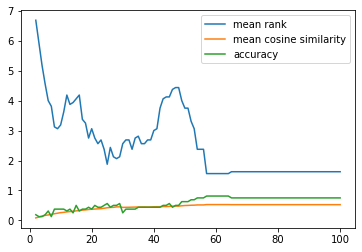

In [609]:
# Plot mean rank/mean cosine similarity/accuracy against the max doc frequency values
plt.plot(max_frequency, mean_rank_,label="mean rank")
plt.plot(max_frequency, mean_cosine_similarity,label="mean cosine similarity")
plt.plot(max_frequency, accuracy,label="accuracy")
plt.legend()

In [610]:
frequency.iloc[45:70]

,max_frequency,mean_rank,mean_cosine_similarity,accuracy
45,47,4.4375,0.475433,0.5000
46,48,4.4375,0.475433,0.5000
47,49,4.0000,0.486285,0.6250
48,50,3.7500,0.495440,0.6250
49,51,3.7500,0.499049,0.6250
50,52,3.3125,0.505251,0.6875
51,53,3.0625,0.507617,0.6875
52,54,2.3750,0.515232,0.7500
53,55,2.3750,0.515232,0.7500
54,56,2.3750,0.515232,0.7500


**Based on the table result and the plot above, the optimal value for maximum document frequency could range *from 57 to 64*. Here, we will choose the *value 64* as maximum document frequency (highest value in the range) for our model**

### Combine all efforts, to achieve better performance in question 2, we will mainly modify these 2 functions: 'pre_process' and 'to_feature_vector_dictionary'

In [611]:
# final 'pre_process' function for question 2
def pre_process(character_text):
    stopword = stopwords.words("english") # Initialize stopword list
    lemmatizer = WordNetLemmatizer() # Initialize lemmatizer
    tokens = word_tokenize(character_text) # use word_tokenize method for cleaner tokens
    tokens = [word.lower() for word in tokens] # Convert into lowercase
    tokens = [word for word in tokens if word.isalpha() or word == '_eol_' or word == '_EOL_'] # Remove punctuation but still keep "_EOL_"
    tokens = [word for word in tokens if not word in stopword] # Stopword removal
    try:
        tokens = [lemmatizer.lemmatize(word, pos = "v") for word in tokens] # Lemmatize verbs
        tokens = [lemmatizer.lemmatize(word, pos = "n") for word in tokens] # Lemmatize nouns
        tokens = [lemmatizer.lemmatize(word, pos = "a") for word in tokens] # Lemmatize adjectives
        tokens = [lemmatizer.lemmatize(word, pos = "r") for word in tokens] # Lemmatize adverbs
        tokens = [lemmatizer.lemmatize(word, pos = "s") for word in tokens] # Lemmatize satellite adjectives
    except:
        pass
    
    extra_feature = []
    
    # Extract bigrams
    ngram = ngrams(tokens, 2)
    for i in ngram:
        bigrams = i[0] + "@" + i[1]
        extra_feature.append(bigrams)
        
    # Extract 4grams
    ngram = ngrams(tokens, 4)
    for i in ngram:
        _4grams = i[0] + "@" + i[1] + '@' + i[2] + '@' + i[3]
        extra_feature.append(_4grams)
    
    return tokens, extra_feature

In [612]:
# final 'to_feature_vector_dictionary' function for question 2
def to_feature_vector_dictionary(character_doc, extra_features):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    
    # Set max doc frequency (insight from the above analysis)
    for key, value in counts.copy().items():
        if value > 64:
            del counts[key]
            
    # Add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        if feature not in counts.keys():
            counts[feature] = 1
        else:
            counts[feature] += 1
    return counts  

In [613]:
# final performance for question 2 with chosen adjustment for functions

# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)

# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]
training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True) # transform the train_feature_matrix

# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False) # transform the val_feature_matrix, don't fit

# Print result
mean_rank, mean_cosine_simliarity, acc, df, correct, test_labels = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
print("mean rank", mean_rank)
print("mean cosine similarity", mean_cosine_simliarity)
print(correct, "correct out of", len(test_labels), "/ accuracy:", acc)

mean rank 1.5625
mean cosine similarity 0.5266782816509554
13 correct out of 16 / accuracy: 0.8125


# Question 3

First, plot the heatmap with the most updated result from question 2

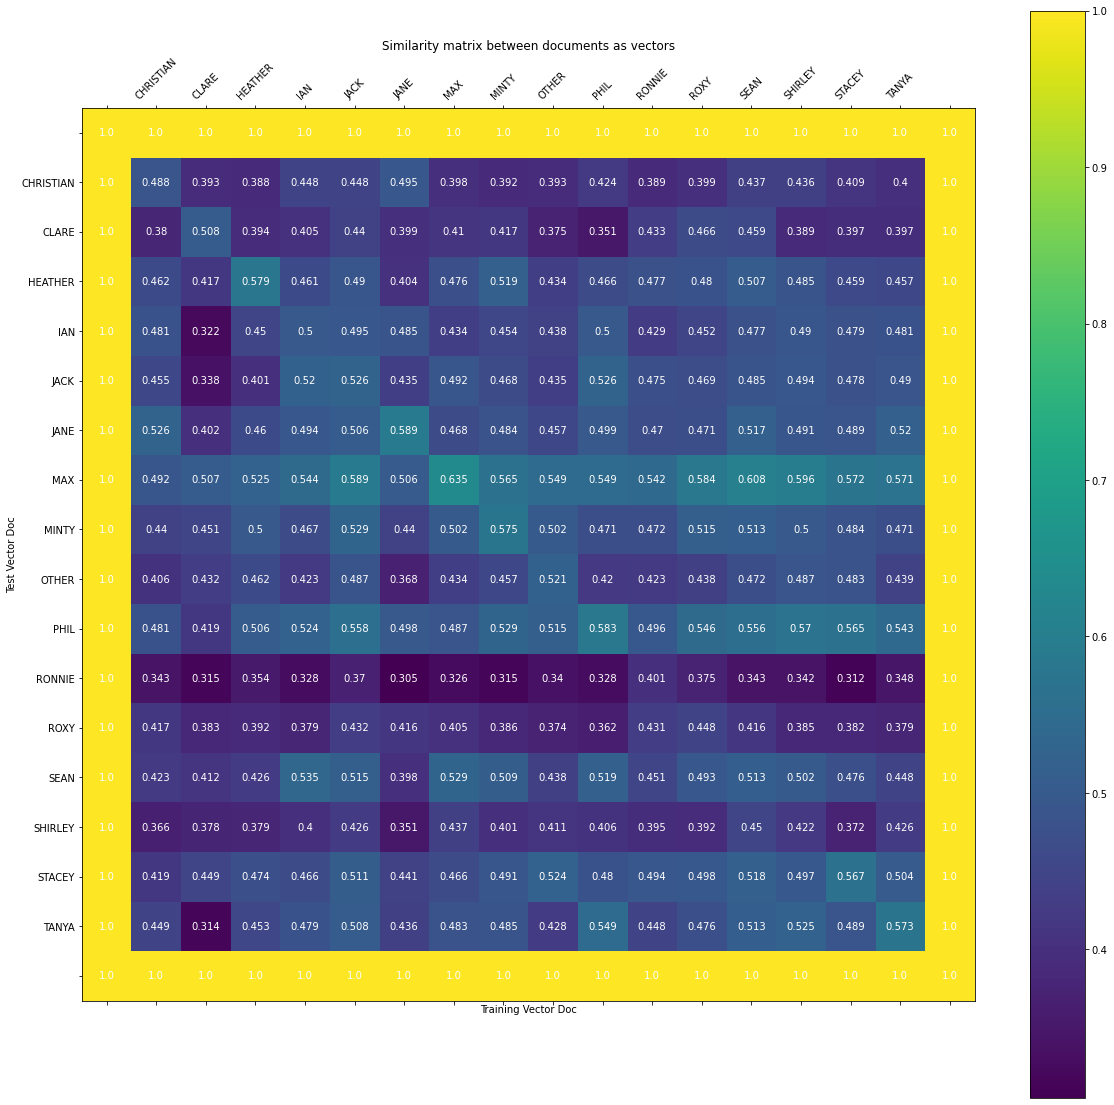

In [614]:
# Using the heatmap function defined at the beginning
plot_heat_map_similarity(df)

From the heatmap display, it can be easily seen that:
- Heldout character vector 'MAX' and 'PHIL' show to be closet (high similarity) to different training character vectors, such as 'SEAN', 'STACY' or 'JACK', but not themselves
- 'RONNIE' in heldout character vector seems to be furthest to other training character vectors (darker color, compared to others)

To be more clear, we can use pandas to identify the heldout character vectors ranked closest to each character's training vector which are not the character themselves, and those furthest away.

In [615]:
# the heldout character vectors ranked CLOSET to each character's training vector which are not the character themselves
df[df['doc1'] != df['doc2']].sort_values(by='similarity', ascending=False).iloc[:10]

,doc1,doc2,similarity
108,MAX,SEAN,0.607647
109,MAX,SHIRLEY,0.595916
100,MAX,JACK,0.589309
107,MAX,ROXY,0.584349
110,MAX,STACEY,0.571963
111,MAX,TANYA,0.571043
157,PHIL,SHIRLEY,0.569585
158,PHIL,STACEY,0.565444
103,MAX,MINTY,0.564588
148,PHIL,JACK,0.557650


In [616]:
# the heldout character vectors ranked FURTHEST to each character's training vector which are not the character themselves
df[df['doc1'] != df['doc2']].sort_values(by='similarity').iloc[:10]

,doc1,doc2,similarity
165,RONNIE,JANE,0.305183
174,RONNIE,STACEY,0.312044
241,TANYA,CLARE,0.313849
161,RONNIE,CLARE,0.314890
167,RONNIE,MINTY,0.315328
49,IAN,CLARE,0.321617
166,RONNIE,MAX,0.326470
169,RONNIE,PHIL,0.328124
163,RONNIE,IAN,0.328165
65,JACK,CLARE,0.338367


Extract the BoW of 'MAX' in heldout vector and 'SEAN' in training vector to examine the reason why the similarity score is high though they are not the same person

Also, to be more clear, print out 'RONNIE' in heldout vector and 'JANE' in training one to see why they can be given the more sensible similarity score (different character = low similarity score)

In [617]:
# Print out the BoW of 'MAX' in heldout vector 
for name, doc in val_corpus:
    if name == "MAX":
        a = Counter(doc[0])
        pos=[]
        for i,v in pos_tag(doc[0]):
            pos.append(v[:2])
        c = Counter(pos)
        b = Counter(doc[1])
        print(a)
        print(b)
        print(c)

Counter({'_eol_': 40, 'get': 9, 'want': 8, 'go': 8, 'right': 7, 'know': 6, 'well': 6, 'tan': 5, 'tanya': 4, 'na': 4, 'could': 4, 'think': 4, 'make': 4, 'oscar': 3, 'year': 3, 'wine': 3, 'girl': 3, 'tell': 3, 'like': 3, 'abi': 3, 'everything': 3, 'u': 3, 'would': 3, 'life': 3, 'mean': 3, 'say': 3, 'two': 3, 'come': 3, 'gon': 3, 'old': 3, 'mate': 3, 'give': 2, 'kid': 2, 'ai': 2, 'bottle': 2, 'yeah': 2, 'good': 2, 'time': 2, 'thing': 2, 'without': 2, 'point': 2, 'away': 2, 'odds': 2, 'start': 2, 'need': 2, 'bad': 2, 'always': 2, 'really': 2, 'rather': 2, 'call': 2, 'oh': 2, 'work': 2, 'look': 2, 'anything': 2, 'twenty': 2, 'alright': 2, 'wan': 1, 'new': 1, 'kiss': 1, 'expose': 1, 'bet': 1, 'anyone': 1, 'ya': 1, 'sit': 1, 'jack': 1, 'bodyguard': 1, 'psychopath': 1, 'roof': 1, 'boy': 1, 'okay': 1, 'lettuce': 1, 'bite': 1, 'confuse': 1, 'lauren': 1, 'prepare': 1, 'around': 1, 'help': 1, 'erase': 1, 'happen': 1, 'bundle': 1, 'chuck': 1, 'huge': 1, 'imagine': 1, 'beat': 1, 'something': 1, 'mov

In [618]:
# Print out the BoW of 'SEAN' in training vector 
for name, doc in training_corpus:
    if name == "SEAN":
        a = Counter(doc[0])
        pos=[]
        for i,v in pos_tag(doc[0]):
            pos.append(v[:2])
        c = Counter(pos)
        b = Counter(doc[1])
        print(a)
        print(b)
        print(c)

Counter({'_eol_': 360, 'get': 46, 'know': 35, 'go': 28, 'think': 26, 'want': 25, 'well': 24, 'na': 22, 'gon': 20, 'tanya': 19, 'like': 19, 'yeah': 19, 'back': 18, 'max': 17, 'alright': 17, 'look': 16, 'take': 16, 'come': 14, 'say': 14, 'make': 13, 'right': 13, 'mean': 12, 'tell': 12, 'need': 11, 'see': 11, 'would': 11, 'way': 11, 'let': 10, 'ai': 9, 'day': 9, 'much': 8, 'good': 8, 'ca': 8, 'minute': 8, 'stacey': 8, 'thing': 7, 'night': 7, 'sorry': 7, 'something': 7, 'last': 6, 'nothing': 6, 'call': 6, 'stace': 6, 'head': 6, 'wo': 6, 'eh': 6, 'time': 6, 'bed': 6, 'leave': 5, 'anyway': 5, 'still': 5, 'sure': 5, 'change': 5, 'old': 5, 'dunno': 5, 'kill': 5, 'maybe': 5, 'tan': 5, 'okay': 5, 'care': 5, 'feel': 5, 'oh': 5, 'hear': 5, 'next': 5, 'try': 5, 'work': 5, 'pretty': 4, 'everything': 4, 'happen': 4, 'course': 4, 'idea': 4, 'worry': 4, 'kid': 4, 'use': 4, 'wonder': 4, 'pop': 4, 'bite': 4, 'dead': 4, 'start': 4, 'hey': 4, 'drink': 4, 'one': 4, 'problem': 4, 'choice': 4, 'lie': 4, 'coul

In [619]:
# Print out the BoW of 'RONNIE' in heldout vector 
for name, doc in val_corpus:
    if name == "RONNIE":
        a = Counter(doc[0])
        pos=[]
        for i,v in pos_tag(doc[0]):
            pos.append(v[:2])
        c = Counter(pos)
        b = Counter(doc[1])
        print(a)
        print(b)
        print(c)

Counter({'_eol_': 40, 'roxy': 8, 'get': 4, 'tell': 4, 'never': 4, 'well': 3, 'say': 3, 'see': 3, 'really': 3, 'gon': 3, 'na': 3, 'time': 3, 'stand': 3, 'open': 2, 'make': 2, 'business': 2, 'stuff': 2, 'ever': 2, 'hard': 2, 'man': 2, 'find': 2, 'would': 2, 'dawn': 2, 'move': 2, 'late': 2, 'clear': 2, 'let': 2, 'happy': 2, 'armpit': 1, 'egg': 1, 'mayonnaise': 1, 'quick': 1, 'scarper': 1, 'town': 1, 'leave': 1, 'tod': 1, 'dunno': 1, 'midnight': 1, 'lunch': 1, 'oppose': 1, 'okay': 1, 'philand': 1, 'auntie': 1, 'peg': 1, 'take': 1, 'buffet': 1, 'pat': 1, 'dress': 1, 'forget': 1, 'something': 1, 'neither': 1, 'yesterday': 1, 'pretty': 1, 'much': 1, 'since': 1, 'arrive': 1, 'one': 1, 'first': 1, 'sight': 1, 'pow': 1, 'live': 1, 'dream': 1, 'close': 1, 'unavailable': 1, 'might': 1, 'yes': 1, 'near': 1, 'touch': 1, 'although': 1, 'swear': 1, 'must': 1, 'mortify': 1, 'upset': 1, 'honey': 1, 'love': 1, 'family': 1, 'anything': 1, 'hurt': 1, 'even': 1, 'though': 1, 'like': 1, 'bad': 1, 'form': 1, 

In [620]:
# Print out the BoW of 'JANE' in training vector 
for name, doc in training_corpus:
    if name == "JANE":
        a = Counter(doc[0])
        pos=[]
        for i,v in pos_tag(doc[0]):
            pos.append(v[:2])
        c = Counter(pos)
        b = Counter(doc[1])
        print(a)
        print(b)
        print(c)

Counter({'_eol_': 360, 'ian': 51, 'get': 45, 'well': 32, 'go': 28, 'christian': 22, 'know': 17, 'like': 17, 'think': 17, 'yeah': 17, 'say': 16, 'want': 16, 'oh': 13, 'time': 12, 'look': 11, 'right': 10, 'bite': 10, 'see': 10, 'ca': 9, 'steven': 9, 'make': 8, 'good': 8, 'alright': 8, 'last': 7, 'really': 7, 'sorry': 7, 'anything': 7, 'stay': 7, 'one': 7, 'idea': 7, 'come': 7, 'mean': 7, 'gon': 7, 'na': 7, 'course': 7, 'matter': 6, 'two': 6, 'bobby': 6, 'worry': 6, 'week': 6, 'u': 6, 'might': 6, 'could': 6, 'sure': 6, 'kid': 6, 'thing': 6, 'life': 6, 'back': 6, 'way': 5, 'lot': 5, 'yes': 5, 'lucy': 5, 'give': 5, 'do': 5, 'fine': 5, 'exactly': 5, 'take': 5, 'hard': 5, 'love': 5, 'house': 5, 'fuss': 5, 'much': 5, 'um': 5, 'night': 5, 'bad': 4, 'something': 4, 'couple': 4, 'round': 4, 'enough': 4, 'ai': 4, 'try': 4, 'family': 4, 'thank': 4, 'leave': 4, 'would': 4, 'need': 4, 'word': 4, 'hope': 4, 'suppose': 4, 'still': 4, 'fruit': 4, 'never': 4, 'talk': 4, 'sort': 4, 'believe': 4, 'please':

Try to look at case where there isn't a successful highest match between the target character in the training set and that character's vector in the heldout set

In [621]:
df[df['doc1'] == df['doc2']].sort_values(by='similarity').iloc[:10]

,doc1,doc2,similarity
170,RONNIE,RONNIE,0.401118
221,SHIRLEY,SHIRLEY,0.421851
187,ROXY,ROXY,0.448055
0,CHRISTIAN,CHRISTIAN,0.488302
51,IAN,IAN,0.500145
17,CLARE,CLARE,0.507621
204,SEAN,SEAN,0.512568
136,OTHER,OTHER,0.521476
68,JACK,JACK,0.526472
238,STACEY,STACEY,0.567175


In [622]:
# Print out the BoW of 'RONNIE' in heldout vector 
for name, doc in val_corpus:
    if name == "RONNIE":
        a = Counter(doc[0])
        pos=[]
        for i,v in pos_tag(doc[0]):
            pos.append(v[:2])
        c = Counter(pos)
        b = Counter(doc[1])
        print(a)
        print(b)
        print(c)

Counter({'_eol_': 40, 'roxy': 8, 'get': 4, 'tell': 4, 'never': 4, 'well': 3, 'say': 3, 'see': 3, 'really': 3, 'gon': 3, 'na': 3, 'time': 3, 'stand': 3, 'open': 2, 'make': 2, 'business': 2, 'stuff': 2, 'ever': 2, 'hard': 2, 'man': 2, 'find': 2, 'would': 2, 'dawn': 2, 'move': 2, 'late': 2, 'clear': 2, 'let': 2, 'happy': 2, 'armpit': 1, 'egg': 1, 'mayonnaise': 1, 'quick': 1, 'scarper': 1, 'town': 1, 'leave': 1, 'tod': 1, 'dunno': 1, 'midnight': 1, 'lunch': 1, 'oppose': 1, 'okay': 1, 'philand': 1, 'auntie': 1, 'peg': 1, 'take': 1, 'buffet': 1, 'pat': 1, 'dress': 1, 'forget': 1, 'something': 1, 'neither': 1, 'yesterday': 1, 'pretty': 1, 'much': 1, 'since': 1, 'arrive': 1, 'one': 1, 'first': 1, 'sight': 1, 'pow': 1, 'live': 1, 'dream': 1, 'close': 1, 'unavailable': 1, 'might': 1, 'yes': 1, 'near': 1, 'touch': 1, 'although': 1, 'swear': 1, 'must': 1, 'mortify': 1, 'upset': 1, 'honey': 1, 'love': 1, 'family': 1, 'anything': 1, 'hurt': 1, 'even': 1, 'though': 1, 'like': 1, 'bad': 1, 'form': 1, 

In [623]:
# Print out the BoW of 'RONNIE' in training vector 
for name, doc in training_corpus:
    if name == "RONNIE":
        a = Counter(doc[0])
        pos=[]
        for i,v in pos_tag(doc[0]):
            pos.append(v[:2])
        c = Counter(pos)
        b = Counter(doc[1])
        print(a)
        print(b)
        print(c)

Counter({'_eol_': 360, 'get': 34, 'jack': 26, 'go': 25, 'want': 22, 'think': 19, 'yeah': 18, 'know': 18, 'like': 18, 'phil': 16, 'na': 16, 'right': 15, 'say': 15, 'well': 14, 'gon': 14, 'come': 14, 'ca': 13, 'look': 12, 'oh': 12, 'make': 12, 'good': 11, 'nothing': 10, 'see': 10, 'leave': 10, 'talk': 10, 'one': 10, 'work': 9, 'night': 9, 'peg': 9, 'would': 9, 'time': 9, 'drink': 8, 'let': 8, 'late': 8, 'alright': 7, 'take': 7, 'business': 7, 'much': 7, 'could': 7, 'mean': 7, 'really': 7, 'roxy': 7, 'okay': 6, 'sorry': 6, 'yes': 6, 'sure': 6, 'ask': 6, 'promise': 6, 'find': 6, 'help': 6, 'thing': 6, 'anything': 6, 'still': 6, 'club': 6, 'home': 5, 'keep': 5, 'thank': 5, 'auntie': 5, 'way': 5, 'tell': 5, 'try': 5, 'lot': 5, 'u': 5, 'maybe': 5, 'something': 5, 'trust': 5, 'first': 5, 'worry': 5, 'back': 5, 'minute': 4, 'little': 4, 'peggy': 4, 'believe': 4, 'face': 4, 'start': 4, 'ai': 4, 'need': 4, 'max': 4, 'head': 4, 'wo': 4, 'least': 4, 'last': 4, 'day': 4, 'couple': 4, 'even': 4, 'sta

**Some insights taken from the observation of the above cases, which may help to lift up the performance:**
- In the case of different character in heldout and training vector but returning a high similarity score, there exists some potential meaningless/trivial words/tokens which occurs many times (high frequency compared to others), for example: *'eol'/'na'/'oh'/'yeah'/'think'/'get'/'go'/'want'/'think'*

- Also, these trivial tokens have been combined into bigrams features as well (like 'oh@_eol_' or '_eol_@yeah'), making their presence even more highlighted, hence hindering the meaningful tokens with lower frequency. This may be the reason why the model fails to map the same character in validation/training vector.

=> Removing these tokens (unigrams/bigrams) could benefit the model

In [624]:
# Try to remove some trivial tokens which occur many times
def to_feature_vector_dictionary(character_doc, extra_features):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    
    # Set max doc frequency (insight from question 2)
    for key, value in counts.copy().items():
        if value > 64:
            del counts[key]
            
    # Add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        if feature not in counts.keys():
            counts[feature] = 1
        else:
            counts[feature] += 1

    # Del some trivial tokens happening many times
    del_list = ['get', 'know', 'go', 'think', 'want', '_eol_', 'well', 'yeah', 'oh', 'na', '_eol_@_eol_', '_eol_@yeah', '_eol_@get', '_eol_@go', '_eol_@want', '_eol_@think', '_eol_@know', 'get@_eol_', 'go@_eol_', 'know@_eol_', 'yeah@_eol_', 'think@_eol_', 'want@_eol_', 'oh@_eol_', '_eol_@oh']
    for key, value in counts.copy().items():
        if key in del_list:
            del counts[key]
    return counts  

In [625]:
# final performance for question 3 with chosen adjustment for functions

# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)

# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]
training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True) # transform the train_feature_matrix

# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False) # transform the val_feature_matrix, don't fit

# Print result
mean_rank, mean_cosine_simliarity, acc, df, correct, test_labels = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
print("mean rank", mean_rank)
print("mean cosine similarity", mean_cosine_simliarity)
print(correct, "correct out of", len(test_labels), "/ accuracy:", acc)

mean rank 1.0
mean cosine similarity 0.3909939727653019
16 correct out of 16 / accuracy: 1.0


***Seems like it is a wise decision to consider removing such tokens, this insight would be taken into account in the final model (question 6)***

# Question 4

In [626]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    character_docs = {}
    character_line_count = {}
    previous_line = {}
    after_line = {}
    scene_info = {}
    for index, (line, name, gender, eps, scene) in enumerate(zip(df.Line, df.Character_name, df.Gender, df.episode_scene, df.Scene_info)):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
            previous_line[name] = ""
            after_line[name] = ""
            scene_info[name] = {}
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line) + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
        scene_info[name][scene] = True

        # After line
        if index == 0 and df.iloc[index+1]['episode_scene'] == eps and df.iloc[index+1]['Character_name'] != name:
            after_line[name] += str(df.iloc[index+1]['Line']) + " _EOL_ "
        elif index > 0 and index < (len(df)-1) and df.iloc[index+1]['episode_scene'] == eps and df.iloc[index+1]['Character_name'] != name:
            after_line[name] += str(df.iloc[index+1]['Line']) + " _EOL_ "
        
        # Previous line
        if index == (len(df)-1) and df.iloc[index-1]['episode_scene'] == eps and df.iloc[index-1]['Character_name'] != name:
            previous_line[name] += str(df.iloc[index-1]['Line']) + " _EOL_ "
        elif index > 0 and index < (len(df)-1) and df.iloc[index-1]['episode_scene'] == eps and df.iloc[index-1]['Character_name'] != name:
            previous_line[name] += str(df.iloc[index-1]['Line']) + " _EOL_ "
    
    return character_docs, previous_line, after_line, scene_info

In [627]:
def pre_process(character_text, previous_line, after_line, context=True):
    stopword = stopwords.words("english") # Initialize stopword list
    lemmatizer = WordNetLemmatizer() # Initialize lemmatizer
    tokens = word_tokenize(character_text) # use word_tokenize method for cleaner tokens
    tokens = [word.lower() for word in tokens] # Convert into lowercase
    tokens = [word for word in tokens if word.isalpha() or word == '_eol_' or word == '_EOL_'] # Remove punctuation but still keep "_EOL_"
    tokens = [word for word in tokens if not word in stopword] # Stopword removal
    try:
        tokens = [lemmatizer.lemmatize(word, pos = "v") for word in tokens] # Lemmatize verbs
        tokens = [lemmatizer.lemmatize(word, pos = "n") for word in tokens] # Lemmatize nouns
        tokens = [lemmatizer.lemmatize(word, pos = "a") for word in tokens] # Lemmatize adjectives
        tokens = [lemmatizer.lemmatize(word, pos = "r") for word in tokens] # Lemmatize adverbs
        tokens = [lemmatizer.lemmatize(word, pos = "s") for word in tokens] # Lemmatize satellite adjectives
    except:
        pass
    
    extra_feature = []
    
    # Extract bigrams
    ngram = ngrams(tokens, 2)
    for i in ngram:
        bigrams = i[0] + "@" + i[1]
        extra_feature.append(bigrams)
        
    # Extract 4grams
    ngram = ngrams(tokens, 4)
    for i in ngram:
        _4grams = i[0] + "@" + i[1] + '@' + i[2] + '@' + i[3]
        extra_feature.append(_4grams)
            
    # Context
    if context:
        for name, doc in previous_line.items():
            token = word_tokenize(doc)
            token = [word.lower() for word in token]
            token = [word for word in token if word.isalpha() or word == '_eol_'] # Remove punctuation
            token = [word for word in token if not word in stopword] # Stopword removal
            token = [word for word in token if word.isalpha()] # Remove punctuation
            try:
                token = [lemmatizer.lemmatize(word, pos = "v") for word in token] # Lemmatize verbs
                token = [lemmatizer.lemmatize(word, pos = "n") for word in token] # Lemmatize nouns
                token = [lemmatizer.lemmatize(word, pos = "a") for word in token] # Lemmatize adjectives
                token = [lemmatizer.lemmatize(word, pos = "r") for word in token] # Lemmatize adverbs
                token = [lemmatizer.lemmatize(word, pos = "s") for word in token] # Lemmatize satellite adjectives
            except:
                pass
            token = ["previous@" + sub for sub in token]
            for i in token:
                extra_feature.append(i)
            
        for name, doc in after_line.items():
            token = word_tokenize(doc)
            token = [word.lower() for word in token]
            token = [word for word in token if word.isalpha() or word == '_eol_'] # Remove punctuation
            token = [word for word in token if not word in stopword] # Stopword removal
            token = [word for word in token if word.isalpha()] # Remove punctuation
            try:
                token = [lemmatizer.lemmatize(word, pos = "v") for word in token] # Lemmatize verbs
                token = [lemmatizer.lemmatize(word, pos = "n") for word in token] # Lemmatize nouns
                token = [lemmatizer.lemmatize(word, pos = "a") for word in token] # Lemmatize adjectives
                token = [lemmatizer.lemmatize(word, pos = "r") for word in token] # Lemmatize adverbs
                token = [lemmatizer.lemmatize(word, pos = "s") for word in token] # Lemmatize satellite adjectives
            except:
                pass
            token = ["after@" + sub for sub in token]
            for i in token:
                extra_feature.append(i)
    
    return tokens, extra_feature

In [628]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts

def create_document_matrix_from_corpus(corpus, scene_info, fitting=False):
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc[0], doc[1], scene_info[name]) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc[0], doc[1], scene_info[name]) for name, doc in corpus])

    return doc_feature_matrix

In [629]:
# Redefine the 'to_feature_vector_dictionary' with a function to set the maximum document frequency
def max_doc_freq_for_context(dictionary, max_freq):
    for key, value in dictionary.copy().items():
        if value > max_freq and key.startswith("previous@"):
            del dictionary[key]
        if value > max_freq and key.startswith("after@"):
            del dictionary[key]

def to_feature_vector_dictionary(character_doc, extra_features, scene_info):
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    
    # Set max doc frequency (insight from question 2)
    for key, value in counts.copy().items():
        if value > 64:
            del counts[key]
    
    # Add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        if feature not in counts.keys():
            counts[feature] = 1
        else:
            counts[feature] += 1
    
    # Set max doc frequency for context
    max_doc_freq_for_context(counts)
    
    # Update Scene info
    counts.update(scene_info)
    
    return counts  

In [630]:
# Use exhaustive method to evaluate possible values for max doc frequency for context (from 2 to 30)

max_frequency = []
mean_rank_ = []
mean_cosine_similarity = []
accuracy = []
for i in range(2,31):
    def max_doc_freq_for_context(dictionary, max_freq=i):
        for key, value in dictionary.copy().items():
            if value > max_freq and key.startswith("previous@"):
                del dictionary[key]
            if value > max_freq and key.startswith("after@"):
                del dictionary[key]
    # print out the number of words each character has in the training set
    # only use the first 360 lines of each character
    train_character_docs, train_previous_line, train_after_line, train_scene_info = create_character_document_from_dataframe(train_data, max_line_count=360)

    # create list of pairs of (character name, pre-processed character) 
    training_corpus = [(name, pre_process(doc, train_previous_line, train_after_line)) for name, doc in sorted(train_character_docs.items())]
    train_labels = [name for name, doc in training_corpus]
    training_feature_matrix = create_document_matrix_from_corpus(training_corpus, train_scene_info, fitting=True) # transform the train_feature_matrix

    # get the validation data- only 40 lines used for each character
    val_character_docs, val_previous_line, val_after_line, val_scene_info = create_character_document_from_dataframe(val_data, max_line_count=40)

    # create list of pairs of (character name, pre-processed character) 
    val_corpus = [(name, pre_process(doc, val_previous_line, val_after_line)) for name, doc in sorted(val_character_docs.items())]
    val_labels = [name for name, doc in val_corpus]
    val_feature_matrix = create_document_matrix_from_corpus(val_corpus, val_scene_info, fitting=False) # transform the val_feature_matrix, don't fit

    # Print result
    mean_rank, mean_cosine_simliarity, acc, df, correct, test_labels = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
    max_frequency.append(i)
    mean_rank_.append(mean_rank)
    mean_cosine_similarity.append(mean_cosine_simliarity)
    accuracy.append(acc)
    
frequency = pd.DataFrame(max_frequency, columns=['max_frequency'])
frequency['mean_rank'] = mean_rank_
frequency['mean_cosine_similarity'] = mean_cosine_similarity
frequency['accuracy'] = accuracy

frequency.sort_values(by='mean_rank', ascending=True).head(10)

,max_frequency,mean_rank,mean_cosine_similarity,accuracy
0,2,1.5625,0.441749,0.8125
1,3,1.5625,0.433138,0.7500
2,4,1.5625,0.427516,0.7500
3,5,1.5625,0.440787,0.6875
16,18,1.6250,0.580498,0.7500
13,15,1.6250,0.552618,0.7500
12,14,1.6250,0.536356,0.7500
11,13,1.6250,0.531590,0.7500
10,12,1.6250,0.521227,0.7500
14,16,1.6250,0.558207,0.7500


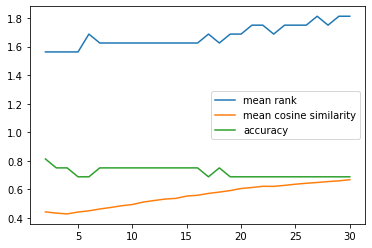

In [631]:
# Plot mean rank/mean cosine similarity/accuracy against the max doc frequency values
plt.plot(max_frequency, mean_rank_,label="mean rank")
plt.plot(max_frequency, mean_cosine_similarity,label="mean cosine similarity")
plt.plot(max_frequency, accuracy,label="accuracy")
plt.legend()

**Given the tuning above, we will choose maximum document frequency for context feature as 2 (lowest mean rank and highest accuracy)**

In [634]:
def to_feature_vector_dictionary(character_doc, extra_features, scene_info):
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    
    # Set max doc frequency (insight from question 2)
    for key, value in counts.copy().items():
        if value > 57:
            del counts[key]
    
    # Add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        if feature not in counts.keys():
            counts[feature] = 1
        else:
            counts[feature] += 1
    
    # Set max doc frequency for context features: (choose value 2)
    for key, value in counts.copy().items():
        if value > 2 and key.startswith("previous@"):
            del counts[key]
        if value > 2 and key.startswith("after@"):
            del counts[key]
    
    # Scene info
    counts.update(scene_info)
    
    return counts  

In [635]:
# final performance for question 4 with chosen adjustment for functions

# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs, train_previous_line, train_after_line, train_scene_info = create_character_document_from_dataframe(train_data, max_line_count=360)

# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc, train_previous_line, train_after_line)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]
training_feature_matrix = create_document_matrix_from_corpus(training_corpus, train_scene_info, fitting=True) # transform the train_feature_matrix

# get the validation data- only 40 lines used for each character
val_character_docs, val_previous_line, val_after_line, val_scene_info = create_character_document_from_dataframe(val_data, max_line_count=40)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc, val_previous_line, val_after_line)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, val_scene_info, fitting=False) # transform the val_feature_matrix, don't fit

# Print result
mean_rank, mean_cosine_simliarity, acc, df, correct, test_labels = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
print("mean rank", mean_rank)
print("mean cosine similarity", mean_cosine_simliarity)
print(correct, "correct out of", len(test_labels), "/ accuracy:", acc)

mean rank 1.5625
mean cosine similarity 0.44174933458389787
13 correct out of 16 / accuracy: 0.8125


# Question 5

The strategy is to implement tf-idf method with all possible hyperparameter combinations, then choose the optimal set to have the best performance

In [636]:
# Implement tf-idf
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts

# import tf-idf method from sklearn and initialize the transformer
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer() # initialize tf-idf transformer

def create_document_matrix_from_corpus(corpus, scene_info, fitting=False):
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc[0], doc[1], scene_info[name]) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc[0], doc[1], scene_info[name]) for name, doc in corpus])
    
    if fitting:
        tfidf_transformer.fit(doc_feature_matrix) # fit tf-idf
    doc_feature_matrix = tfidf_transformer.transform(doc_feature_matrix) # transform using tf-idf

    return doc_feature_matrix

Tuning the hyperparameters in tf-idf transformer to select the set returning the best performance

In [637]:
# create a dictionary contains all values of hyperparameters of tf-idf
params = {'norm' : ['l1', 'l2'], 'use_idf':[True, False], 'smooth_idf':[True, False], 'sublinear_tf':[True, False]}

# Create all combinations from params (in total there are 16 combinations)
from itertools import product

keys, values = zip(*params.items())
params_comb = [dict(zip(keys, p)) for p in product(*values)]

# Looping through all params combination and return the performance score for each
for i in params_comb:
    norm_, use_idf_, smooth_idf_, sublinear_tf_ = list(i.values())
    tfidf_transformer=TfidfTransformer(norm = str(norm_), 
                                       use_idf = use_idf_, 
                                       smooth_idf = smooth_idf_, 
                                       sublinear_tf = sublinear_tf_)
    # print out the number of words each character has in the training set
    # only use the first 360 lines of each character
    train_character_docs, train_previous_line, train_after_line, train_scene_info = create_character_document_from_dataframe(train_data, max_line_count=360)

    # create list of pairs of (character name, pre-processed character) 
    training_corpus = [(name, pre_process(doc, train_previous_line, train_after_line)) for name, doc in sorted(train_character_docs.items())]
    train_labels = [name for name, doc in training_corpus]
    training_feature_matrix = create_document_matrix_from_corpus(training_corpus, train_scene_info, fitting=True) # transform the train_feature_matrix

    # get the validation data- only 40 lines used for each character
    val_character_docs, val_previous_line, val_after_line, val_scene_info = create_character_document_from_dataframe(val_data, max_line_count=40)

    # create list of pairs of (character name, pre-processed character) 
    val_corpus = [(name, pre_process(doc, val_previous_line, val_after_line)) for name, doc in sorted(val_character_docs.items())]
    val_labels = [name for name, doc in val_corpus]
    val_feature_matrix = create_document_matrix_from_corpus(val_corpus, val_scene_info, fitting=False) # transform the val_feature_matrix, don't fit

    # Print result
    mean_rank, mean_cosine_simliarity, acc, df, correct, test_labels = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
    print('The params set used (norm - use_idf - smooth_idf - sublinear_tf): ', [norm_, use_idf_, smooth_idf_, sublinear_tf_])
    print("mean rank", mean_rank)
    print("mean cosine similarity", mean_cosine_simliarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", acc)
    print('\n')

The params set used (norm - use_idf - smooth_idf - sublinear_tf):  ['l1', True, True, True]
mean rank 1.1875
mean cosine similarity 0.14073975213580672
13 correct out of 16 / accuracy: 0.8125


The params set used (norm - use_idf - smooth_idf - sublinear_tf):  ['l1', True, True, False]
mean rank 1.1875
mean cosine similarity 0.2736161473877339
13 correct out of 16 / accuracy: 0.8125


The params set used (norm - use_idf - smooth_idf - sublinear_tf):  ['l1', True, False, True]
mean rank 1.1875
mean cosine similarity 0.12041761836569391
13 correct out of 16 / accuracy: 0.8125


The params set used (norm - use_idf - smooth_idf - sublinear_tf):  ['l1', True, False, False]
mean rank 1.1875
mean cosine similarity 0.24098684379291924
13 correct out of 16 / accuracy: 0.8125


The params set used (norm - use_idf - smooth_idf - sublinear_tf):  ['l1', False, True, True]
mean rank 1.0625
mean cosine similarity 0.2856335422930243
15 correct out of 16 / accuracy: 0.9375


The params set used (norm -

After evaluating all hyperparameter combinations of tf-idf method, below is the one with best performance:
- {norm='l1', use_idf=False, smooth_idf=True, sublinear_tf=True}
- {norm='l1', use_idf=False, smooth_idf=False, sublinear_tf=True}
- {norm='l2', use_idf=False, smooth_idf=True, sublinear_tf=True}
- {norm='l2', use_idf=False, smooth_idf=False, sublinear_tf=True}

We will use one of the above four. In this case, we will choose **{norm='l2', use_idf=False, smooth_idf=True, sublinear_tf=True}**

In [638]:
# final performance for question 5 with chosen adjustment for functions

tfidf_transformer=TfidfTransformer(norm = 'l2', use_idf = False, smooth_idf = True, sublinear_tf = True)
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs, train_previous_line, train_after_line, train_scene_info = create_character_document_from_dataframe(train_data, max_line_count=360)

# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc, train_previous_line, train_after_line)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]
training_feature_matrix = create_document_matrix_from_corpus(training_corpus, train_scene_info, fitting=True) # transform the train_feature_matrix

# get the validation data- only 40 lines used for each character
val_character_docs, val_previous_line, val_after_line, val_scene_info = create_character_document_from_dataframe(val_data, max_line_count=40)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc, val_previous_line, val_after_line)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, val_scene_info, fitting=False) # transform the val_feature_matrix, don't fit

# Print result
mean_rank, mean_cosine_simliarity, acc, df, correct, test_labels = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
print("mean rank", mean_rank)
print("mean cosine similarity", mean_cosine_simliarity)
print(correct, "correct out of", len(test_labels), "/ accuracy:", acc)

mean rank 1.0625
mean cosine similarity 0.2856335422930243
15 correct out of 16 / accuracy: 0.9375


# Question 6

I will select all the best modified function achieved from previous questions. The other function (not listed below) would be remained the same as what is given at the begining of the coursework

Final 'create_character_document_from_dataframe' function

In [639]:
def create_character_document_from_dataframe(df, max_line_count):
    character_docs = {}
    character_line_count = {}
    previous_line = {}
    after_line = {}
    scene_info = {}
    for index, (line, name, gender, eps, scene) in enumerate(zip(df.Line, df.Character_name, df.Gender, df.episode_scene, df.Scene_info)):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
            previous_line[name] = ""
            after_line[name] = ""
            scene_info[name] = {}
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line) + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
        scene_info[name][scene] = True

        # After line
        if index == 0 and df.iloc[index+1]['episode_scene'] == eps and df.iloc[index+1]['Character_name'] != name:
            after_line[name] += str(df.iloc[index+1]['Line']) + " _EOL_ "
        elif index > 0 and index < (len(df)-1) and df.iloc[index+1]['episode_scene'] == eps and df.iloc[index+1]['Character_name'] != name:
            after_line[name] += str(df.iloc[index+1]['Line']) + " _EOL_ "
        
        # Previous line
        if index == (len(df)-1) and df.iloc[index-1]['episode_scene'] == eps and df.iloc[index-1]['Character_name'] != name:
            previous_line[name] += str(df.iloc[index-1]['Line']) + " _EOL_ "
        elif index > 0 and index < (len(df)-1) and df.iloc[index-1]['episode_scene'] == eps and df.iloc[index-1]['Character_name'] != name:
            previous_line[name] += str(df.iloc[index-1]['Line']) + " _EOL_ "
    
    return character_docs, previous_line, after_line, scene_info

Final 'pre_process' function

In [640]:
def pre_process(character_text, previous_line, after_line, context=True):
    stopword = stopwords.words("english") # Initialize stopword list
    lemmatizer = WordNetLemmatizer() # Initialize lemmatizer
    tokens = word_tokenize(character_text) # use word_tokenize method for cleaner tokens
    tokens = [word.lower() for word in tokens] # Convert into lowercase
    tokens = [word for word in tokens if word.isalpha() or word == '_eol_' or word == '_EOL_'] # Remove punctuation but still keep "_EOL_"
    tokens = [word for word in tokens if not word in stopword] # Stopword removal
    try:
        tokens = [lemmatizer.lemmatize(word, pos = "v") for word in tokens] # Lemmatize verbs
        tokens = [lemmatizer.lemmatize(word, pos = "n") for word in tokens] # Lemmatize nouns
        tokens = [lemmatizer.lemmatize(word, pos = "a") for word in tokens] # Lemmatize adjectives
        tokens = [lemmatizer.lemmatize(word, pos = "r") for word in tokens] # Lemmatize adverbs
        tokens = [lemmatizer.lemmatize(word, pos = "s") for word in tokens] # Lemmatize satellite adjectives
    except:
        pass
    
    extra_feature = []
    
    # Extract bigrams
    ngram = ngrams(tokens, 2)
    for i in ngram:
        bigrams = i[0] + "@" + i[1]
        extra_feature.append(bigrams)
        
    # Extract 4grams
    ngram = ngrams(tokens, 4)
    for i in ngram:
        _4grams = i[0] + "@" + i[1] + '@' + i[2] + '@' + i[3]
        extra_feature.append(_4grams)
            
    # Context
    if context:
        for name, doc in previous_line.items():
            token = word_tokenize(doc)
            token = [word.lower() for word in token]
            token = [word for word in token if word.isalpha() or word == '_eol_'] # Remove punctuation
            token = [word for word in token if not word in stopword] # Stopword removal
            token = [word for word in token if word.isalpha()] # Remove punctuation
            try:
                token = [lemmatizer.lemmatize(word, pos = "v") for word in token] # Lemmatize verbs
                token = [lemmatizer.lemmatize(word, pos = "n") for word in token] # Lemmatize nouns
                token = [lemmatizer.lemmatize(word, pos = "a") for word in token] # Lemmatize adjectives
                token = [lemmatizer.lemmatize(word, pos = "r") for word in token] # Lemmatize adverbs
                token = [lemmatizer.lemmatize(word, pos = "s") for word in token] # Lemmatize satellite adjectives
            except:
                pass
            token = ["previous@" + sub for sub in token]
            for i in token:
                extra_feature.append(i)
            
        for name, doc in after_line.items():
            token = word_tokenize(doc)
            token = [word.lower() for word in token]
            token = [word for word in token if word.isalpha() or word == '_eol_'] # Remove punctuation
            token = [word for word in token if not word in stopword] # Stopword removal
            token = [word for word in token if word.isalpha()] # Remove punctuation
            try:
                token = [lemmatizer.lemmatize(word, pos = "v") for word in token] # Lemmatize verbs
                token = [lemmatizer.lemmatize(word, pos = "n") for word in token] # Lemmatize nouns
                token = [lemmatizer.lemmatize(word, pos = "a") for word in token] # Lemmatize adjectives
                token = [lemmatizer.lemmatize(word, pos = "r") for word in token] # Lemmatize adverbs
                token = [lemmatizer.lemmatize(word, pos = "s") for word in token] # Lemmatize satellite adjectives
            except:
                pass
            token = ["after@" + sub for sub in token]
            for i in token:
                extra_feature.append(i)
    
    return tokens, extra_feature

Final 'to_feature_vector_dictionary' function

In [647]:
def to_feature_vector_dictionary(character_doc, extra_features, scene_info):
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    
    # Set max doc frequency (insight from question 2)
    for key, value in counts.copy().items():
        if value > 64:
            del counts[key]
    
    # Add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        if feature not in counts.keys():
            counts[feature] = 1
        else:
            counts[feature] += 1
    
    # Set max doc frequency for context features: (choose value 3)
    for key, value in counts.copy().items():
        if value > 2 and key.startswith("previous@"):
            del counts[key]
        if value > 2 and key.startswith("after@"):
            del counts[key]
    
    # Scene info
    counts.update(scene_info)
    
    return counts  

Final 'create_document_matrix_from_corpus' function

In [648]:
# Implement tf-idf
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts

# import tf-idf method from sklearn and initialize the transformer
tfidf_transformer=TfidfTransformer(norm = 'l2', use_idf = False, smooth_idf = True, sublinear_tf = True)

def create_document_matrix_from_corpus(corpus, scene_info, fitting=False):
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc[0], doc[1], scene_info[name]) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc[0], doc[1], scene_info[name]) for name, doc in corpus])
    
    if fitting:
        tfidf_transformer.fit(doc_feature_matrix) # fit tf-idf
    doc_feature_matrix = tfidf_transformer.transform(doc_feature_matrix) # transform using tf-idf

    return doc_feature_matrix

Performance on held-out set **WITHOUT using the insights from question 3 (remove trivial tokens)**

In [649]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs, train_previous_line, train_after_line, train_scene_info = create_character_document_from_dataframe(train_data, max_line_count=360)

# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc, train_previous_line, train_after_line)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]
training_feature_matrix = create_document_matrix_from_corpus(training_corpus, train_scene_info, fitting=True) # transform the train_feature_matrix

# get the validation data- only 40 lines used for each character
val_character_docs, val_previous_line, val_after_line, val_scene_info = create_character_document_from_dataframe(val_data, max_line_count=40)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc, val_previous_line, val_after_line)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, val_scene_info, fitting=False) # transform the val_feature_matrix, don't fit

# Print result
mean_rank, mean_cosine_simliarity, acc, df, correct, test_labels = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
print("mean rank", mean_rank)
print("mean cosine similarity", mean_cosine_simliarity)
print(correct, "correct out of", len(test_labels), "/ accuracy:", acc)

mean rank 1.0625
mean cosine similarity 0.2856335422930243
15 correct out of 16 / accuracy: 0.9375


Performance on held-out set **using the insights from question 3 (remove trivial tokens)**

In [650]:
# Modify function 'to_feature_vector_dictionary' with insights from q3
def to_feature_vector_dictionary(character_doc, extra_features, scene_info):
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    
    # Set max doc frequency (insight from question 2)
    for key, value in counts.copy().items():
        if value > 64:
            del counts[key]
    
    # Add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        if feature not in counts.keys():
            counts[feature] = 1
        else:
            counts[feature] += 1
    
    # Set max doc frequency for context features: (choose value 2)
    for key, value in counts.copy().items():
        if value > 2 and key.startswith("previous@"):
            del counts[key]
        if value > 2 and key.startswith("after@"):
            del counts[key]
    
    # Scene info
    counts.update(scene_info)
    
    # Del some trivial words happening many times (insight from question 3)
    del_list = ['get', 'know', 'go', 'think', 'want', '_eol_', 'well', 'yeah', 'oh', 'na', '_eol_@_eol_', '_eol_@yeah', '_eol_@get', '_eol_@go', '_eol_@want', '_eol_@think', '_eol_@know', 'get@_eol_', 'go@_eol_', 'know@_eol_', 'yeah@_eol_', 'think@_eol_', 'want@_eol_', 'oh@_eol_', '_eol_@oh']
    for key, value in counts.copy().items():
        if key in del_list:
            del counts[key]
    
    return counts  

# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs, train_previous_line, train_after_line, train_scene_info = create_character_document_from_dataframe(train_data, max_line_count=360)

# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc, train_previous_line, train_after_line)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]
training_feature_matrix = create_document_matrix_from_corpus(training_corpus, train_scene_info, fitting=True) # transform the train_feature_matrix

# get the validation data- only 40 lines used for each character
val_character_docs, val_previous_line, val_after_line, val_scene_info = create_character_document_from_dataframe(val_data, max_line_count=40)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc, val_previous_line, val_after_line)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, val_scene_info, fitting=False) # transform the val_feature_matrix, don't fit

# Print result
mean_rank, mean_cosine_simliarity, acc, df, correct, test_labels = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
print("mean rank", mean_rank)
print("mean cosine similarity", mean_cosine_simliarity)
print(correct, "correct out of", len(test_labels), "/ accuracy:", acc)

mean rank 1.0625
mean cosine similarity 0.26365555605755786
15 correct out of 16 / accuracy: 0.9375


Whether using the insights from question 3 or not, the performance remains unchanged for mean rank and accuracy, so we can use either of it.

In [654]:
def to_feature_vector_dictionary(character_doc, extra_features, scene_info):
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    
    # Set max doc frequency (insight from question 2)
    for key, value in counts.copy().items():
        if value > 64:
            del counts[key]
    
    # Add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        if feature not in counts.keys():
            counts[feature] = 1
        else:
            counts[feature] += 1
    
    # Set max doc frequency for context features: (choose value 2)
    for key, value in counts.copy().items():
        if value > 2 and key.startswith("previous@"):
            del counts[key]
        if value > 2 and key.startswith("after@"):
            del counts[key]
    
    # Scene info
    counts.update(scene_info)
    
    # Del some trivial words happening many times (insight from question 3)
    del_list = ['get', 'know', 'go', 'think', 'want', '_eol_', 'well', 'yeah', 'oh', 'na', '_eol_@_eol_', '_eol_@yeah', '_eol_@get', '_eol_@go', '_eol_@want', '_eol_@think', '_eol_@know', 'get@_eol_', 'go@_eol_', 'know@_eol_', 'yeah@_eol_', 'think@_eol_', 'want@_eol_', 'oh@_eol_', '_eol_@oh']
    for key, value in counts.copy().items():
        if key in del_list:
            del counts[key]
    
    return counts 

Use **test dataset** to generate the final performance

In [655]:
# redo on all training data with the first 400 character lines used
train_character_docs, train_previous_line, train_after_line, train_scene_info = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc, train_previous_line, train_after_line)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


training_feature_matrix = create_document_matrix_from_corpus(training_corpus, train_scene_info, fitting=True)

# get the test data using 40 lines per character
epsiode_scene_column = test_data.Episode.astype(str) + "-" + test_data.Scene.astype(str)
test_data['episode_scene'] = epsiode_scene_column

test_character_docs, test_previous_line, test_after_line, test_scene_info = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc, test_previous_line, test_after_line)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, test_scene_info, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df, correct, test_labels = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)
print('\n')
print('Final performance with test data')
print("mean rank", mean_rank)
print("mean cosine similarity", mean_cosine_simliarity)
print(correct, "correct out of", len(test_labels), "/ accuracy:", acc)

Num. Characters:  16 

SHIRLEY Number of Words:  4233
OTHER Number of Words:  3606
JACK Number of Words:  4786
RONNIE Number of Words:  3872
TANYA Number of Words:  4214
SEAN Number of Words:  4026
ROXY Number of Words:  4200
HEATHER Number of Words:  4504
MAX Number of Words:  5107
IAN Number of Words:  4863
JANE Number of Words:  4117
STACEY Number of Words:  4325
PHIL Number of Words:  4103
MINTY Number of Words:  4391
CHRISTIAN Number of Words:  4250
CLARE Number of Words:  4844
total words 69441
Num. Characters:  16 

SHIRLEY Number of Words:  373
OTHER Number of Words:  453
HEATHER Number of Words:  451
PHIL Number of Words:  406
SEAN Number of Words:  466
TANYA Number of Words:  465
MAX Number of Words:  494
JACK Number of Words:  412
IAN Number of Words:  509
JANE Number of Words:  414
STACEY Number of Words:  634
ROXY Number of Words:  392
RONNIE Number of Words:  390
CHRISTIAN Number of Words:  629
MINTY Number of Words:  428
CLARE Number of Words:  368
total words 7284


Fin

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9088\932186355.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9088\932186355.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9088\932186355.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9088\932186355.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9088\932186355.py:10: UserWarning: Boolean Series key will be reindexed to ma

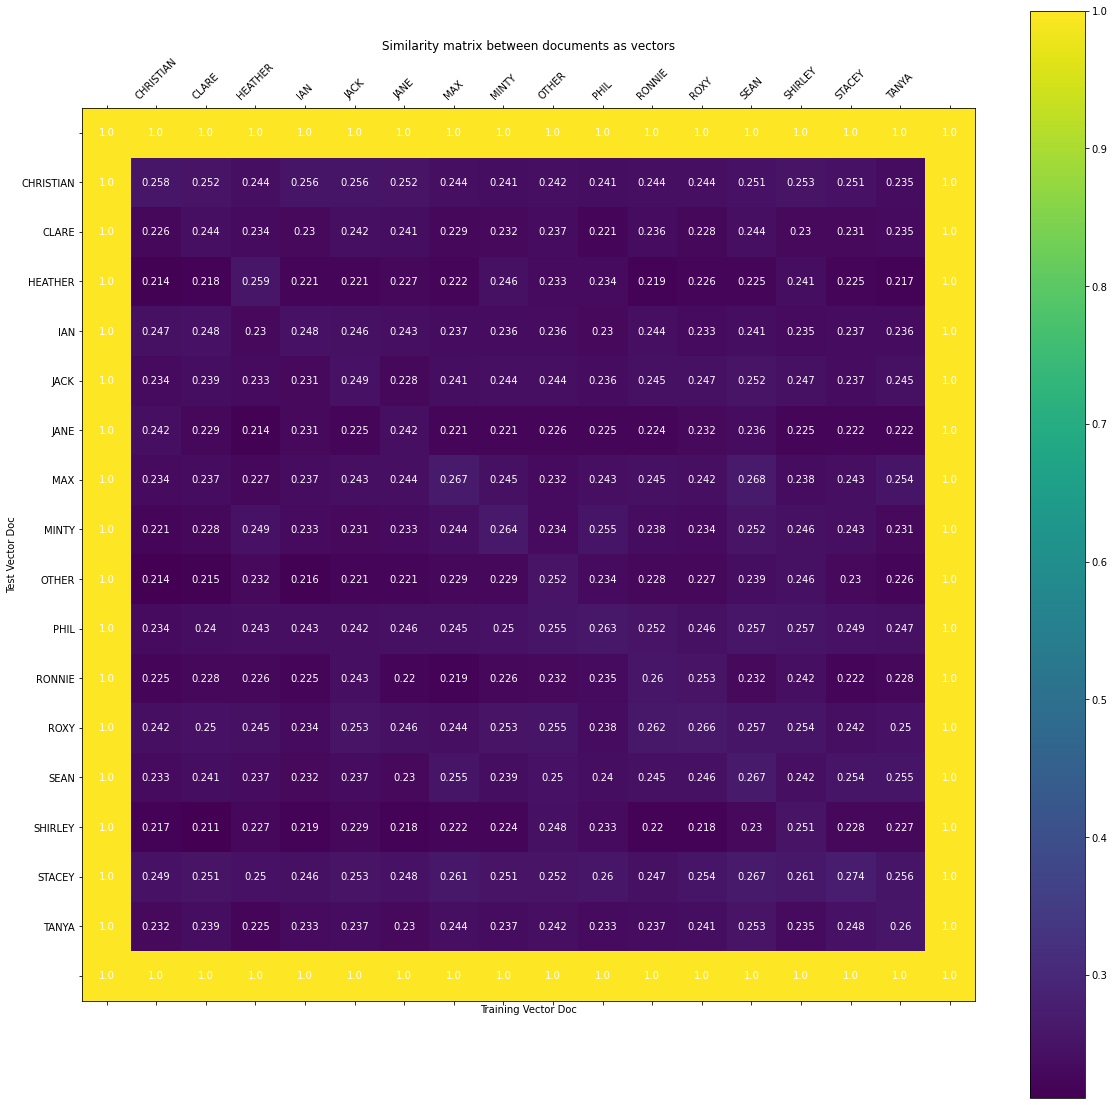

In [656]:
plot_heat_map_similarity(df)